# Whole atmosphere Jacobians
### Multi-layer atmosphere with $H_2 O$, $CO_2$, and $O_2$
### Using HITRAN, `jax`, and NVIDIA GPUs

Jacobian going through the whole atmosphere, and some convolution experiments

May 2020

In [1]:
import astropy.units as u
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import hapi
hapi.db_begin('../../hapi/data/')

from jax.config import config
config.update("jax_enable_x64", False)

import jax.numpy as np
from jax import vmap, jit, grad, random
from jax.lax import stop_gradient
from jax import jacfwd
from functools import partial

import pandas as pd

HAPI version: 1.1.0.9.7
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using ../../hapi/data/

H2O
                     Lines parsed: 70039
CO2
                     Lines parsed: 69523
O2
                     Lines parsed: 679


In [2]:
! du -hs ../../hapi/data/*.data

11M	../../hapi/data/CO2.data
11M	../../hapi/data/H2O.data
108K	../../hapi/data/O2.data


In [3]:
@jit
def gamma_of_p_and_T(p, T, p_self, n_air, gamma_air_ref, gamma_self_ref):
    '''Compute the Lorentz HWHM with pressure and temp'''
    return (296.0/T)**n_air *(gamma_air_ref*(p-p_self) + gamma_self_ref*(p_self))

In [4]:
@jit
def lorentz_profile(nu, p, nu_ij, gamma, dp_ref, S_ij):
    '''Return the Lorentz line profile given vectors and parameters'''
    return S_ij/np.pi * gamma / ( gamma**2 + (nu - (nu_ij + dp_ref*p))**2)

In [5]:
@jit
def tips_Q_of_T(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return np.sum( g_k * np.exp(- c_2 * E_k / T) )

In [6]:
@jit
def S_ij_of_T(T, S_ij_296, nu_ij, g_lower, E_lower):
    '''The Spectral Line Intensity'''
    c_2 = 1.4387770 #cm K
    return (S_ij_296 * 
            stop_gradient(tips_Q_of_T(296.0, g_lower, E_lower)) / 
            tips_Q_of_T(T, g_lower, E_lower) *
            np.exp(-c_2 * E_lower/T) /np.exp(-c_2 * E_lower/296.0) *
           (1-np.exp(-c_2*nu_ij/T) )/(1-np.exp(-c_2*nu_ij/296.0)))

In [7]:
@jit
def transmission_of_T_p(T, p, nus, vol_mix_ratio, atomic_data):
    '''Return the absorption coefficient as a function of T'''
    
    (n_air, gamma_air, gamma_self, E_lower, g_lower,\
     nu_lines, delta_air, S_ij_296) = atomic_data
    
    gammas = vmap(gamma_of_p_and_T, in_axes=(None, None, None, 0, 0, 0)\
                                )(p, T,vol_mix_ratio, n_air, gamma_air, gamma_self)
    
    S_ij = S_ij_of_T(T, S_ij_296, nu_lines, g_lower, E_lower)
    
    abs_coeff = vmap(lorentz_profile, in_axes=(None, None, 0, 0,0, 0))(nus, p,
                                     nu_lines, gammas, delta_air, S_ij).sum(axis=0)
    #path_length_km = 1.0
    tau = abs_coeff * (vol_mix_ratio*2.688392857142857e+19) * (1.0*100000.0)
    return np.exp(-tau)

### Compute the transmission spectrum

Requires a path length.  Let's assume constant density of the Earth's atmosphere, and 3 km path length.

The HITRAN absorption coefficient $\alpha$ units are: $cm^{−1}/(molecule⋅cm^{−2})$

So we have the optical depth:

$$ \tau_{ij}(\nu, T, p) = \alpha \cdot n \cdot \ell$$

where $n$ is the number density of particles, and $\ell$ is the path length.

In [8]:
def get_hapi_molec_data(species):
    '''return the order columns in device arrays
    TODO: a bit fragile, consider returning a dict instead!
    '''
    ordered_cols = ['n_air','gamma_air','gamma_self','elower','gpp','nu','delta_air','sw']
    return [np.array(hapi.getColumn(species, col)) for col in ordered_cols]

In [9]:
#(n_air, gamma_air, gamma_self, E_lower, g_lower, nu_lines, delta_air, S_ij_296) = get_hapi_molec_data('H2O')

## Get the atmospheric profile from TDAS  
Follow the prescription from Kevin Gullikson:
https://telfit.readthedocs.io/en/latest/GDAS_atmosphere.html

For now we'll use the average composition profiles from [the same source as TelFit](http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm)

In [10]:
#! wget http://eodg.atm.ox.ac.uk/RFM/atm/ngt.atm
#! mv ngt.atm ../data/

In [11]:
cols = ['HGT [km]','PRE [mb]','TEM [K]','N2 [ppmv]','O2 [ppmv]','CO2 [ppmv]','O3 [ppmv]',
        'H2O [ppmv]','CH4 [ppmv]','N2O [ppmv]','HNO3 [ppmv]','CO [ppmv]','NO2 [ppmv]',
        'N2O5 [ppmv]','ClO [ppmv]','HOCl [ppmv]','ClONO2 [ppmv]','NO [ppmv]','HNO4 [ppmv]',
        'HCN [ppmv]','NH3 [ppmv]','F11 [ppmv]','F12 [ppmv]','F14 [ppmv]','F22 [ppmv]',
        'CCl4 [ppmv]','COF2 [ppmv]','H2O2 [ppmv]','C2H2 [ppmv]','C2H6 [ppmv]','OCS [ppmv]',
        'SO2 [ppmv]','SF6 [ppmv]']

ngt_atm = pd.read_csv('../data/ngt.atm', comment='*', delim_whitespace=True, skiprows=25, names='ABCDE')
ngt_atm = pd.DataFrame(data=ngt_atm.stack().values.reshape(33, 121)).T
ngt_atm.columns = cols

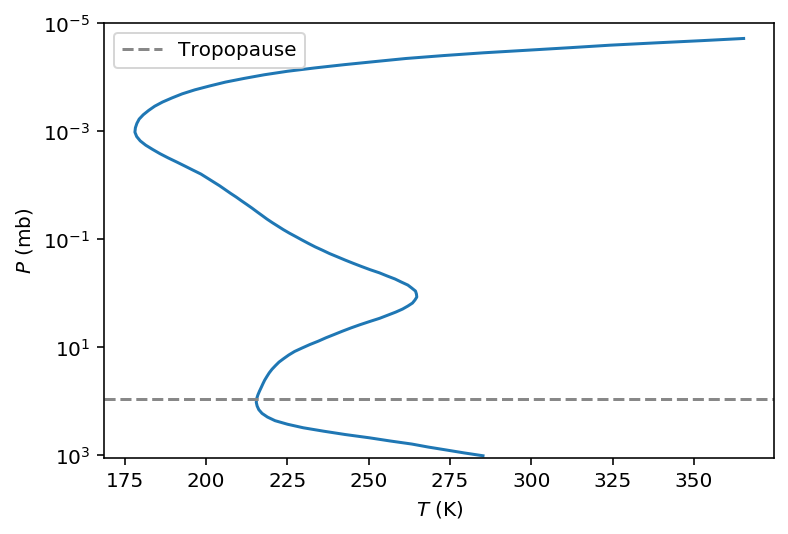

In [12]:
plt.plot(ngt_atm['TEM [K]'], ngt_atm['PRE [mb]'], label=None)
plt.axhline(ngt_atm.loc[17, 'PRE [mb]'], linestyle='dashed', color='#888888', label='Tropopause')
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('$T$ (K)');
plt.legend();

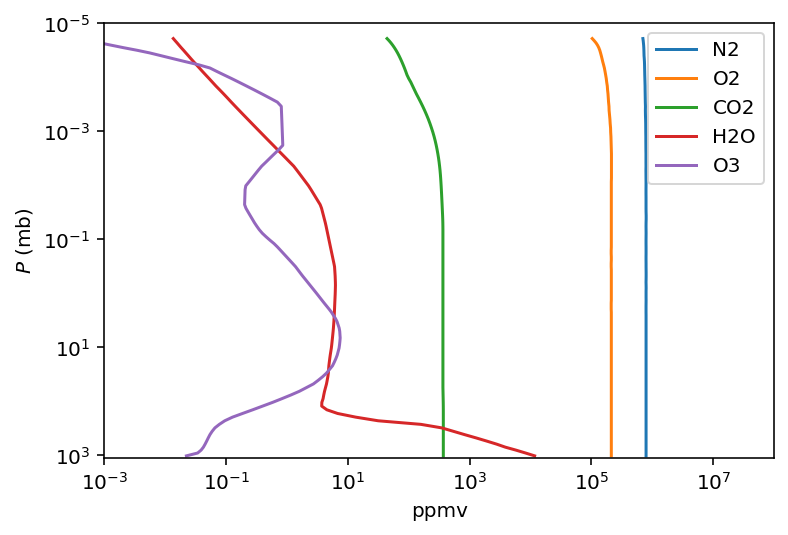

In [13]:
for species in ['N2', 'O2', 'CO2', 'H2O', 'O3']:
    plt.plot(ngt_atm[species+' [ppmv]'], ngt_atm['PRE [mb]'], label=species)
plt.ylim(1100, 1e-5); plt.yscale('log'); plt.ylabel('$P$ (mb)'); plt.xlabel('ppmv');
plt.xlim(1e-3, 1e8); plt.xscale('log'); plt.legend();

### Simulate an observation

In [14]:
@jit
def transmission_multilayer_atmosphere(T_vec, p_vec, vol_mix_ratio, nus, atomic_data=None):
    '''Compute transmission through a mutlilayer atmosphere'''
    
    return vmap(partial(transmission_of_T_p, atomic_data=atomic_data),
                in_axes=(0,0,None,0)
                )(T_vec, P_vec, nus, vol_mix_ratio).prod(axis=0)

In [15]:
wls = np.linspace(8000, 12800, 60000*10)

In [16]:
nus = np.array((wls*u.Angstrom).to(1/u.cm, equivalencies=u.spectral()).value)

In [17]:
nus.shape

(600000,)

In [18]:
import time

McDonald Observatory is at ~ 2km, so just read off from `2:` in steps of km.

In [19]:
T_vec, P_vec, H2O_vec = (np.array(ngt_atm['TEM [K]'].values[2:17]), 
           np.array(ngt_atm['PRE [mb]'].values/1013.25)[2:17],
           np.array(ngt_atm['H2O [ppmv]'].values*1.0e-6)[2:17])

In [20]:
this_dat = get_hapi_molec_data('H2O')

In [21]:
t0 = time.time()
out1 = transmission_multilayer_atmosphere(T_vec, P_vec, H2O_vec, nus, atomic_data=get_hapi_molec_data('H2O'))
print(out1[0], time.time() - t0)

0.99194384 17.792219638824463


In [22]:
O2_vec = np.array(ngt_atm['O2 [ppmv]'].values*1.0e-6)[2:17]

In [23]:
t0 = time.time()
out2 = transmission_multilayer_atmosphere(T_vec, P_vec, O2_vec, nus, 
                                          atomic_data=get_hapi_molec_data('O2'))

print(out2[0], time.time() - t0)

1.0 0.42804431915283203


In [24]:
CO2_vec = np.array(ngt_atm['CO2 [ppmv]'].values*1.0e-6)[2:17]

In [25]:
t0 = time.time()
out3 = transmission_multilayer_atmosphere(T_vec, P_vec, CO2_vec, nus, 
                                          atomic_data=get_hapi_molec_data('CO2'))

print(out3[0], time.time() - t0)

1.0 17.408507108688354


It takes about 1 ms per spectral line, so the water line list takes much longer than the $O_2$ line list.  We can probably get the total time down by not populating the entire matrix of wavelength values for each spectral line.

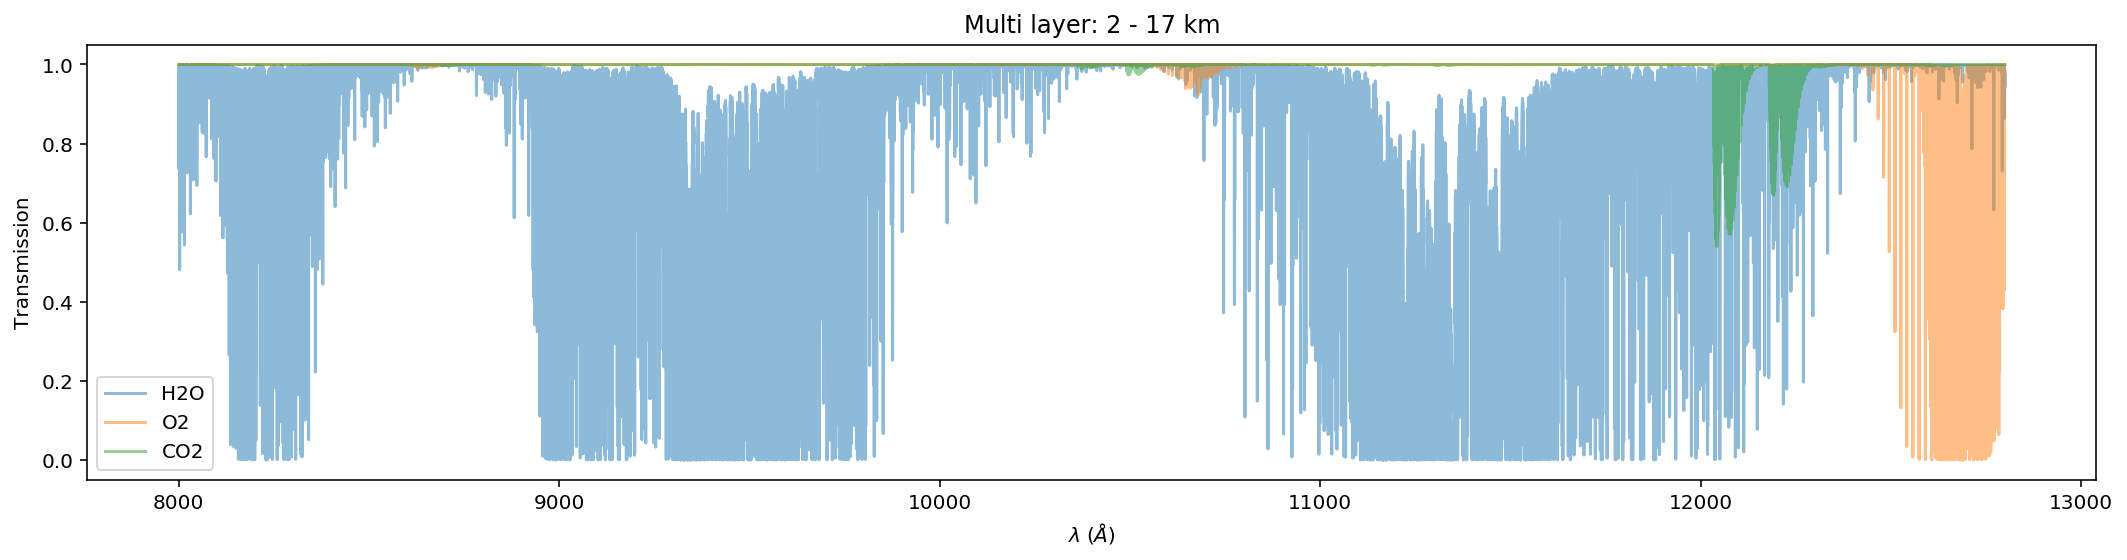

In [26]:
plt.figure(figsize=(18,4))
plt.plot(wls, out1, label='H2O', alpha=0.5)
plt.plot(wls, out2, label='O2', alpha=0.5)
plt.plot(wls, out3, label='CO2', alpha=0.5)

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

Yay!  It works!

Now let's smooth it to the HPF resolution:

In [27]:
sig, mu = 11.5, 0.0
xx = np.linspace(-100, 100, 200)
slit_kernel = 1/(sig*np.sqrt(2*np.pi))*np.exp(-0.5*((xx-mu)/sig)**2) 

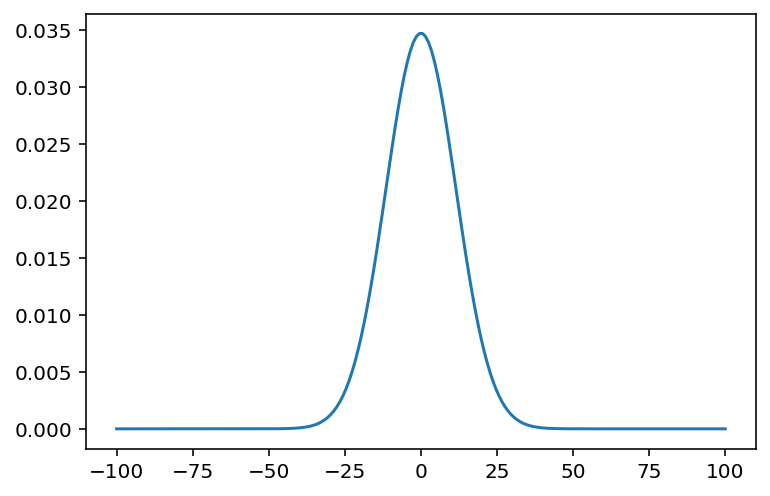

In [28]:
plt.plot(xx, slit_kernel)

In [29]:
%%time
np.convolve(out1, slit_kernel, mode='same').shape

CPU times: user 808 ms, sys: 205 ms, total: 1.01 s
Wall time: 1.3 s


(600000,)

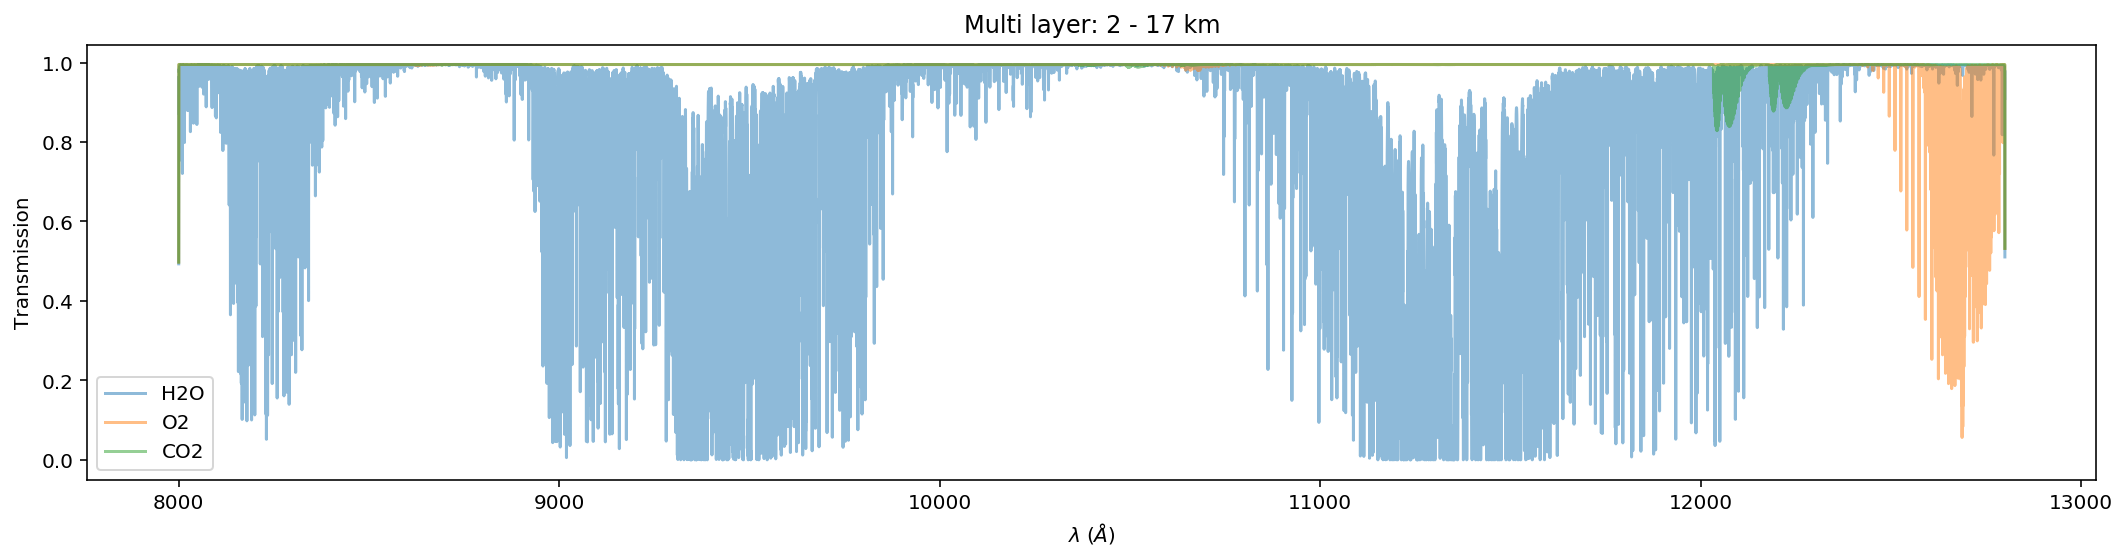

In [30]:
plt.figure(figsize=(18,4))
plt.plot(wls, np.convolve(out1, slit_kernel, mode='same'), label='H2O', alpha=0.5)
plt.plot(wls, np.convolve(out2, slit_kernel, mode='same'), label='O2', alpha=0.5)
plt.plot(wls, np.convolve(out3, slit_kernel, mode='same'), label='CO2', alpha=0.5)

plt.legend(loc='lower left')
plt.ylabel('Transmission')
plt.xlabel('$\lambda \;(\AA)$')
plt.title('Multi layer: 2 - 17 km');

In [47]:
@jit
def nat_log(a,b,c,d, atomic_data=None):
    return np.log(transmission_multilayer_atmosphere(a,b,c,d,atomic_data=atomic_data))

In [62]:
t0 = time.time()
#j0_H2O = jacfwd(np.log(transmission_multilayer_atmosphere), argnums=0)(T_vec, P_vec, H2O_vec, nus, atomic_data=get_hapi_molec_data('H2O'))
j0_O2 = jacfwd(nat_log, argnums=0)(T_vec, P_vec, H2O_vec, nus, atomic_data=get_hapi_molec_data('H2O'))
j1_O2 = jacfwd(nat_log, argnums=1)(T_vec, P_vec, H2O_vec, nus, atomic_data=get_hapi_molec_data('H2O'))
print(j0_O2.shape, j1_O2.shape,time.time()-t0)

(600000, 15) (600000, 15) 629.0939211845398


It took 10 minutes, but my GPU was able to compute the temperature and pressure Jacobians of water through the Earth's multi-layer atmosphere, with line-by-line precision.

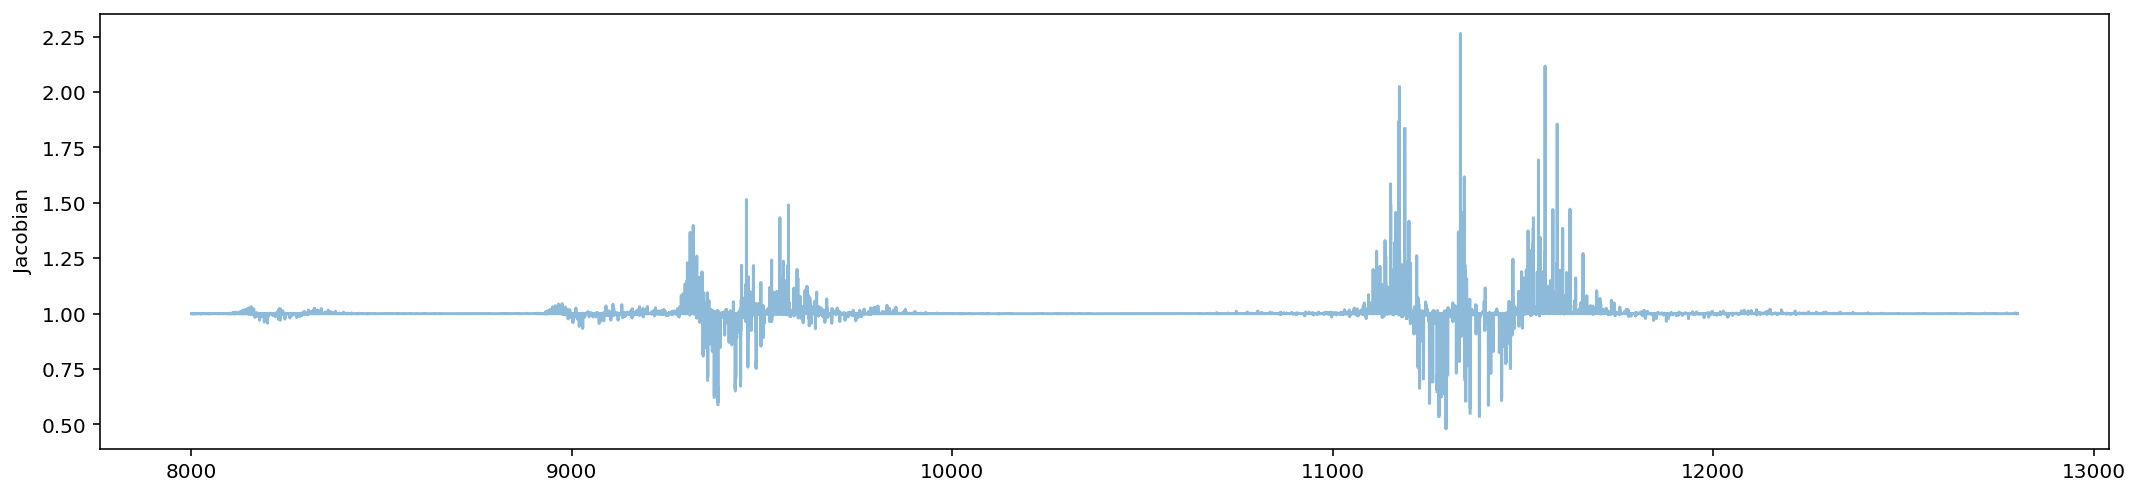

In [64]:
plt.figure(figsize=(18,4))
#plt.plot(wls, np.convolve(j0.sum(axis=1), slit_kernel, mode='same'), label='O2 Temperature Jacobian', alpha=0.5)
plt.plot(wls, np.exp(-j0_O2.sum(axis=1)) , label='O2', alpha=0.5)
plt.ylabel('Jacobian');

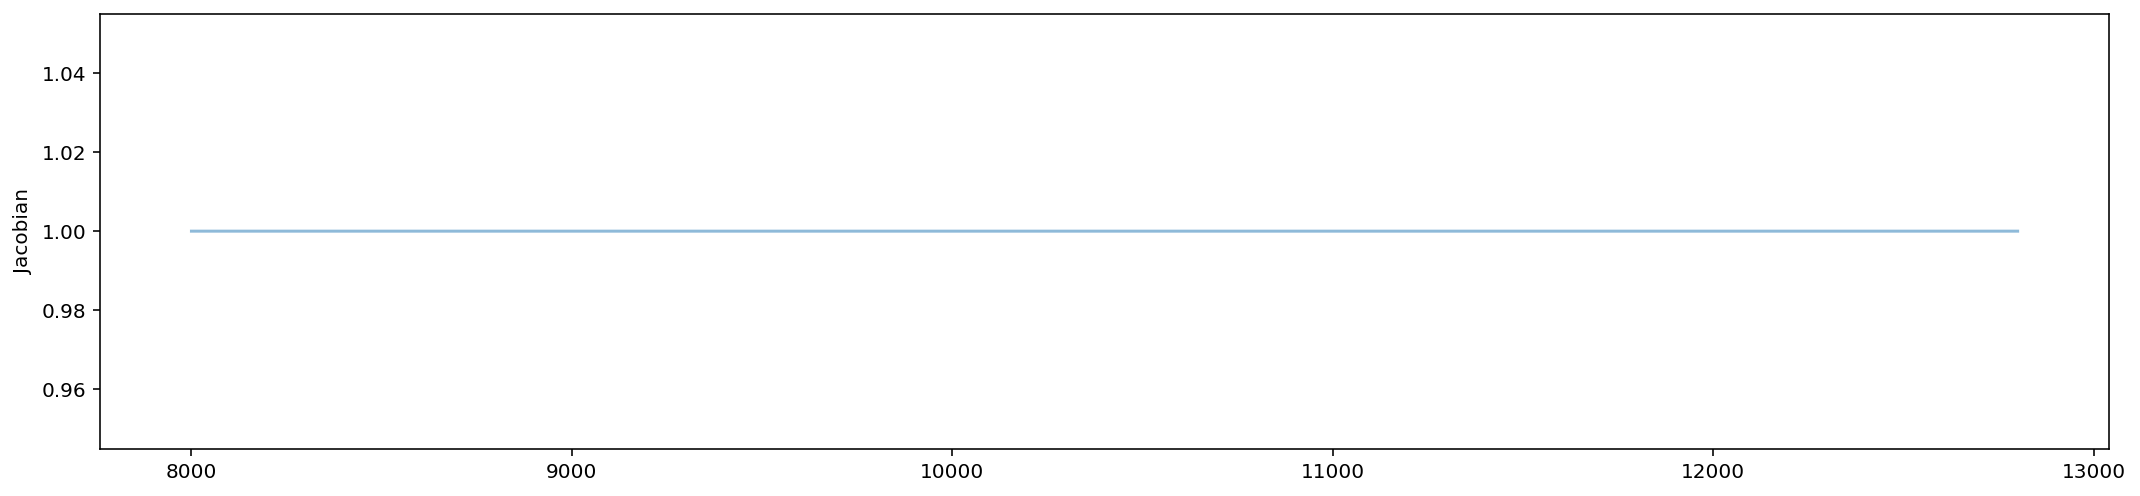

In [66]:
plt.figure(figsize=(18,4))
#plt.plot(wls, np.convolve(j0.sum(axis=1), slit_kernel, mode='same'), label='O2 Temperature Jacobian', alpha=0.5)
plt.plot(wls, np.exp(-j1_O2.sum(axis=1)) , label='H2O', alpha=0.5)
plt.ylabel('Jacobian');

# Fail:
#### 1) The Pressure Jacobian doesn't work for some reason.  


#### 2) The convolution cannot be a pure function  
It's essentially doing a discrete integral, which is numeric by nature.  Somehow autodiff can see-through a convolution though--- how does that work if it's discrete?

#### 3) I should really move some of the re-used functions elsewhere
other than just copy notebooks every time.  But this is an experiment not a package!

# Success

#### 1) The Temperature Jacobian seems to work  
At least in part.  

#### 2) Convolutions work  
Even if their Jacobians don't.

# Hors Categorie

#### 1) The Jacobian for 15 layers took 15x longer than computing the function itself.  
That makes sense though.